# Predicting the noise level of noisy FashionMNIST images

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.

## Imports

In [ ]:
import os
os.environ['OMP_NUM_THREADS']='1'

In [ ]:
import timm, torch, random, datasets, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.nn import init
from fastcore.foundation import L
from torch import nn
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Load dataset

Use 28x28 images, high batch size.

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
n = 1000
sigmas = torch.linspace(0.01, 1.0, n)
xmean,xstd = 0.2859,0.353

In [ ]:
def transformi(b):
    x = (TF.to_tensor(b[xl][0])-xmean)/xstd
    sig = sigmas[random.randrange(0, n)]
    return {xl: [x.lerp(torch.randn(x.shape), sig)], yl: [sig]}

In [ ]:
tdsd = dsd.with_transform(transformi)
tds = tdsd['train']

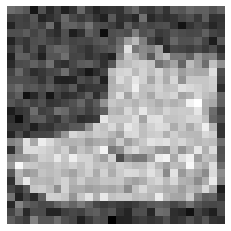

In [ ]:
show_image(tds[0][xl]);

In [ ]:
dls = DataLoaders.from_dd(tdsd, bs, num_workers=fc.defaults.cpus)
dl = dls.train
xb,yb = next(iter(dl))

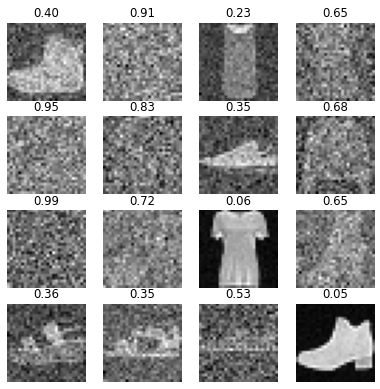

In [ ]:
titles = [f'{o:.2f}' for o in yb[:16]]
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

In [ ]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): return torch.full((len(x),), 0.5)

In [ ]:
metrics = MetricsCB()

In [ ]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=metrics)
learn.fit(1, train=False)

{'loss': '0.083', 'epoch': 0, 'train': 'eval'}


In [ ]:
F.mse_loss(yb,torch.full(yb.shape, 0.5))

tensor(0.08)

In [ ]:
def flat_mse(x,y): return F.mse_loss(x.flatten(), y.flatten())

In [ ]:
opt_func = partial(optim.Adam, eps=1e-5)
epochs = 4
lr = 6e-3

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]
model = timm.create_model('resnet10t', in_chans=1, num_classes=1)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.050,0,train
0.011,0,eval
0.004,1,train
0.003,1,eval
0.002,2,train
0.001,2,eval
0.001,3,train
0.001,3,eval


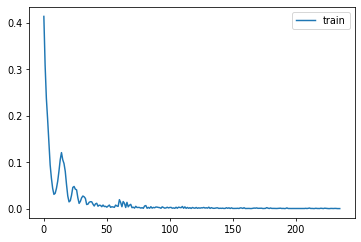

In [ ]:
learn.fit(epochs)

## No-time model

In [ ]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, (t*0).to(device)), ε

In [ ]:
from diffusers import UNet2DModel
from torch.utils.data import DataLoader,default_collate

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
bs = 512

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
@inplace
def transformi(b): b[xl] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.259,0,train
0.029,0,eval
0.028,1,train
0.028,1,eval
0.023,2,train
0.021,2,eval
0.020,3,train
0.020,3,eval
0.019,4,train
0.019,4,eval


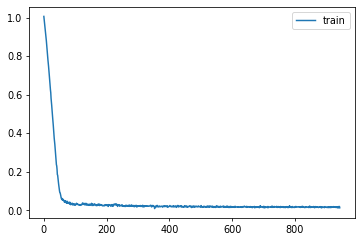

In [ ]:
learn.fit(epochs)

In [ ]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, 0*t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [ ]:
samples = sample(learn.model, (16, 1, 32, 32), alpha, alphabar, sigma, n_steps)

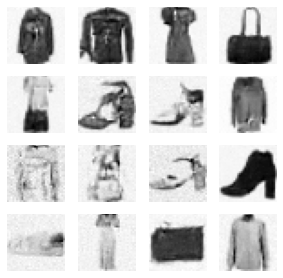

In [ ]:
show_images(samples[-1], figsize=(5,5))